In [1]:
library(foreign)
library(dplyr)
library(stringr
       )
library(foreach)
library(doParallel)
library(LaplacesDemon)
library(glmnet)
library(MASS)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: iterators

Loading required package: parallel

Loading required package: Matrix

Loaded glmnet 3.0-2



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [2]:
desired_clusters <- 30

max_available_clusters <- detectCores()

cl <- makeCluster(min(c(max_available_clusters, desired_clusters))-3)

registerDoParallel(cl)

In [3]:
source('../causal_inference_methods_code_corrupted.R')

In [4]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
  
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}

In [5]:
list.files("./Real Data Analyses")

character(0)

In [6]:
countryData <- foreign::read.dta("repgermany.dta")
countryData <- countryData %>% mutate(reunified = as.numeric(country=="West Germany" & year >= 1990))

countryData  <- countryData %>% filter(year < 1998 & year > 1960)

In [7]:
names(countryData)

[1] "index"     "country"   "year"      "gdp"       "infrate"   "trade"    
 [7] "schooling" "invest60"  "invest70"  "invest80"  "industry"  "reunified"

# Covariate Cleaning

In [8]:
inflationData <- countryData %>% dplyr::select(country, year, infrate)
inflationDataWideForm <- variableExpander(inflationData, "country", "year")

tradeData <- countryData %>% dplyr::select(country, year, trade)
tradeDataWideForm <- variableExpander(tradeData, "country", "year")

industryData <- countryData %>% dplyr::select(country, year, industry)
industryDataWideForm <- variableExpander(industryData, "country", "year")

# Control for Trade and Inflation.


In [9]:
WTrade <- variableExpander(countryData %>% 
                           dplyr::select(country, year, trade) %>% 
                           mutate(noTrade=as.numeric(is.na(trade)))  %>% dplyr::select(country, year, noTrade)
                        , "country", "year")


In [10]:
completedTradeInfo <- completion_with_rank_estimation_validate_mu(Y=tradeDataWideForm, W=WTrade,  
                                                           weight_matrix = NULL,
                                                           initial_rank=40,
                                                           tolerance=1e-04, 
                                                           validation_max_iter=5000,
                                                           min_iter=100,
                                                           max_iter=10000,
                                                           mu_grid=10^seq(-3,3, 1),
                                                           K=5)



In [11]:
inflationDataWithReun <- countryData %>% dplyr::select(country, year, infrate, reunified)

In [12]:
completedTradeData <- reshape::melt(completedTradeInfo$L_hat)

names(completedTradeData) <- c("country", "year", "trade")

allPredData <- completedTradeData %>% inner_join(inflationDataWithReun )

Joining, by = c("country", "year")

Warning message:
“Column `country` joining factor and character vector, coercing into character vector”


In [13]:
allPredDataConstantVars <- (allPredData %>% 
                            group_by(country) %>% summarize(meanTrade= mean(trade),
                                                           meanInf=mean(infrate), 
                                                           reunifiedDuration=sum(reunified)))

mod <- glm(reunified~infrate+trade, data=allPredData , 
           family=poisson())

In [14]:
allPredData$probReunify <- mod$fitted.values

In [15]:
gdpData <- countryData %>% dplyr::select(country, year, gdp)
reunifiedData <- countryData %>% dplyr::select(country, year, reunified)

In [16]:
gdpDataWideForm <- variableExpander(gdpData, "country", "year")
W <- variableExpander(reunifiedData, "country", "year")

In [17]:
propScores <- variableExpander(allPredData[,c("country", "year", "probReunify")], unitKey = 'country', timeKey = 'year')

ourWeightMatrix <- propensity.score.to.weight(propScores, W)

In [23]:
r1comp_info <- completion_with_rank_estimation_validate_mu(Y=gdpDataWideForm, W=W,  
                                                           weight_matrix = ourWeightMatrix,
                                                           initial_rank=60,
                                                           tolerance=1e-04, 
                                                           validation_max_iter=5000,
                                                           min_iter=100,
                                                           max_iter=10000,
                                                           mu_grid=c(0, 10^seq(-3,3, 1)),
                                                           K=5)

In [18]:
stopCluster(cl)

In [24]:
treat.estimator(Y=gdpDataWideForm, L.hat=r1comp_info$L_hat, W=W)

[1] 10222.87 11129.46 11326.41 10776.51 10892.91 11174.35 11610.75 11437.99

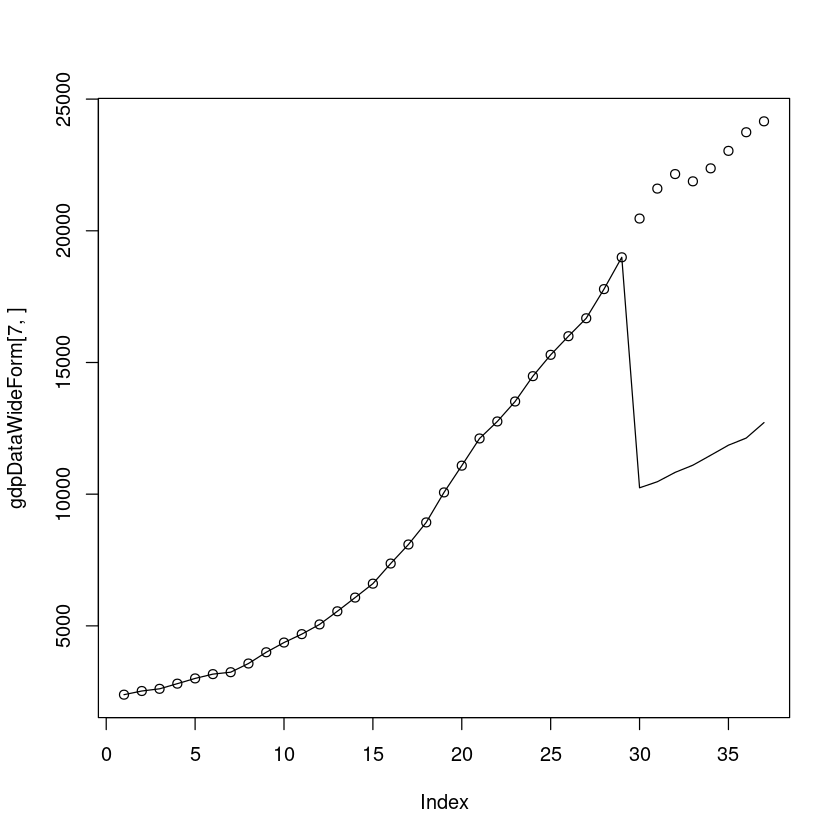

In [25]:
plot(gdpDataWideForm[7,])
lines(r1comp_info$L_hat[7,])

In [60]:
data(mpdta)

In [58]:
library(did)

In [61]:
mpdta

,year,countyreal,lpop,lemp,first.treat,treat
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
866,2003,8001,5.896761,8.461469,2007,1
841,2004,8001,5.896761,8.336870,2007,1
842,2005,8001,5.896761,8.340217,2007,1
819,2006,8001,5.896761,8.378161,2007,1
827,2007,8001,5.896761,8.487352,2007,1
937,2003,8019,2.232377,4.997212,2007,1
938,2004,8019,2.232377,5.081404,2007,1
939,2005,8019,2.232377,4.787492,2007,1
940,2006,8019,2.232377,4.990433,2007,1


In [64]:
?mpdta

mpdta {did},R Documentation
